In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import to_rgb
import seaborn as sns
from langcodes import tag_is_valid, Language
import os

import fasttext
# this module requires  stuff installed
# sudo apt install -y --no-install-recommends g++ protobuf-compiler libprotobuf-dev
import gcld3

from wordcloud import WordCloud
import spacy

sns.set_theme()

# Overview
**Disclaimer:** The entire dataset has more than 8GB. I couldn't work with locally, so in this notebook we analyze a subset with 500000 data points, which is still pretty big. I did, however work with the full dataset on kaggle. For that you can check [this notebook](https://www.kaggle.com/code/carlosgdcj/song-lyrics) (I still ran into problems due to the size of the dataset btw).

Our data has 8 columns: title, tag, artist, year, views, features, lyrics and id. Normally we would load all of them and drop the ones that aren't useful. This dataset however is pretty big, so we load only the interesting features and specify the correct data type to save some memory.

The id column should not be relevant to any analysis as it shouldn't contain any meaningful information. The features column has data on other artist apart from the main one that contributed to the song. This is relevant information, but considering our analisys is mostly concerned with lyrics and this column takes significant amount of space (being a string), we'll drop that as well.

In [2]:
data_path = os.path.join("data", "ds2_toy.csv")
df = pd.read_csv(data_path, usecols=["title", "artist", "year", "tag", "views", "lyrics"], dtype={"year": np.int16, "views": np.int32})

The lyrics column seems to contain a bunch of garbage, like tokens indicating the part of the song (`[Intro], [Chorus]`), metadata (`[Produced by...]`) and special characters like newlines(`\n`). We'll have to deal with that during the preprocessing step.

In [3]:
df.head()

,title,tag,artist,year,views,lyrics
0,Killa Cam,rap,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,Can I Live,rap,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,Forgive Me Father,rap,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...
3,Down and Out,rap,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...
4,Fly In,rap,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."


In [4]:
df.shape

(500000, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   499963 non-null  object
 1   tag     500000 non-null  object
 2   artist  500000 non-null  object
 3   year    500000 non-null  int16 
 4   views   500000 non-null  int32 
 5   lyrics  499280 non-null  object
dtypes: int16(1), int32(1), object(4)
memory usage: 18.1+ MB


Songs are classified in one of 6 genres: rap, rb, rock, pop, misc and country. Considering genius had an initial focus on rap music (discovered this during the analysis), we can expect that group to be heavily present.

In [6]:
df["tag"].unique()

array(['rap', 'rb', 'rock', 'pop', 'misc', 'country'], dtype=object)

# Preprocessing
We start preprocessing by removing N.A. lyrics, as the number of N.A.s is a small percentage of all data, and the lyrics column is our main interest.

In [7]:
# drop N.A. lyrics
df = df.dropna(subset=["lyrics"])

We also remove romanizations, identified by the artist being "Genius Romanizations" or by having (Romanized) in the title. Romanizations can be redundant information, as we could have multiple versions of the same song: [romanized](https://genius.com/Genius-romanizations-tk-from-ling-tosite-sigure-unravel-romanized-lyrics) and not [romanized](https://genius.com/Tk-from-unravel-lyrics). We may end up losing some pretty popular songs, but that's ok, since it's not our main focus.

In [8]:
# drop romanizations
df = df[df["artist"] != "Genius Romanizations"]
df = df[~df["title"].str.contains(r'\(?romanized\)?', regex=True, na=False, case=False)]

The data was collected in 2022, so any value greater than that is some sort of prediction. We remove those. We also deal with duplicated entries by checking the title, the artist and the year. This method may trigger some false positives, however it is good enough for our purposes.

In [9]:
# drop values that make no sense
df = df[df["year"] < 2023]
# remove duplicated entries
df = df.drop_duplicates(subset=["title", "artist", "year"])

To clean the lyrics we remove everything in square brackets when they are at the start of the line. We also substitute new line tokens with a whitespace, meaning we lose the structure of the composition. 

In [10]:
# Clean lyrics a bit (remove [Chorus], [Produced], [Intro])
pattern = r'(?m)^\[.*?\]$'
df["lyrics"] = df["lyrics"].str.replace(pattern, "", regex=True)
pattern = r'\n|\n\n'
df["lyrics"] = df["lyrics"].str.replace(pattern, " ", regex=True)

Songs uploaded to Genius don't pass through a strict verification process, so there can be basically anything. We use a simple heuristic to filter out everything that's too excessive: smaller than 100 characters and greater than 100000 characters.

In [11]:
# drop songs that are too small or too big
# normally too small are complete nonsense and too big are entire books
df = df[df["lyrics"].str.len().between(10 ** 2, 10 ** 5)]

## Identifying song languages
Working with multiple languages is complicated. As our data has no information regarding the language of each song, we can't reallly choose a langauge to work with.

To deal with that we employ two models capable of identifying languages: gcld3 and fasttext. The library `langcodes` is a life saver when it comes to standardizing the output of the models.

In [12]:
# identify lyrics language
gcld3_model = gcld3.NNetLanguageIdentifier(min_num_bytes=10, max_num_bytes=1000)
fasttext_model = fasttext.load_model(os.path.join("data", "lid.176.bin"))

def sanitize_lang_token(token):
    if not tag_is_valid(token):
        print(f"Found unknown language token: {token}")
        return np.nan
    else:
        # "fil" -> Filipino -> "fil"
        # "tl" -> Filipino -> "fil"
        lang_natural_name = Language.get(token).display_name('en')
        return str(Language.find(lang_natural_name, "en"))

def identify_language(text, method):
    if method == "cld3":
        res = gcld3_model.FindLanguage(text=text)
        return sanitize_lang_token(res.language) if res.is_reliable else np.nan
    elif method == "ft":
        res = fasttext_model.predict(text)
        return sanitize_lang_token(res[0][0].removeprefix("__label__")) if res[1][0] >= 0.5 else np.nan

df["language_cld3"] = df["lyrics"].apply(identify_language, args=("cld3", ))
print(f'{len(df[df["language_cld3"].isna()])} not identified lyrics using cld3')
df["language_ft"] = df["lyrics"].apply(identify_language, args=("ft", ))
print(f'{len(df[df["language_ft"].isna()])} not identified lyrics using fasttext')

5342 not identified lyrics using cld3
7474 not identified lyrics using fasttext


In [13]:
df.head()

,title,tag,artist,year,views,lyrics,language_cld3,language_ft
0,Killa Cam,rap,Cam'ron,2004,173166,"Killa Cam, Killa Cam, Cam Killa Cam, Killa Ca...",en,en
1,Can I Live,rap,JAY-Z,1996,468624,"Yeah, hah, yeah, Roc-A-Fella We invite you ...",en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,Maybe cause I'm eatin And these bastards fiend...,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"Ugh, Killa! Baby! Kanye, this that 1970s He...",en,en
4,Fly In,rap,Lil Wayne,2005,78271,"So they ask me ""Young boy What you gon' do th...",en,en


In [14]:
# The cases where fasttext is unsure seem to make more sense but not always
df[(df["language_ft"].isna() ^ df["language_cld3"].isna())].head(10)

,title,tag,artist,year,views,lyrics,language_cld3,language_ft
137,Combination Pizza Hut and Taco Bell,rap,Das Racist,2008,71968,Ha Ha-ha Ha Ha-ha Ha Ha Ha Ha I'm at the Pi...,NaN,en
357,Watagatapitusberry Remix,rap,Pitbull,2010,23034,Black Point (Goddam!) El Cata Sensato del P...,es,NaN
1359,Im Paris Hilton,rap,Lil B,2010,20376,"Ohmigod, ohmigod, ohmigod, Based God, you cam...",NaN,en
1558,I Wanna Be Sedated,rock,Ramones,1978,90801,Twenty-twenty-twenty four hours to go I wanna...,NaN,en
1652,The Reed Beshno as Ney.. from Masnavi,rap,Rumi,2010,8303,Beshno az ney chon hekaayat mikonad Az jodaaye...,so,NaN
2605,Ride On Me,rap,Blade Icewood,2005,8581,"Uh, Yea Heard These Niggas Wanted To Holla At...",en,NaN
2998,Hood Politics,rap,Jeezy,2010,5728,"Hood politics, yeah Hood politics, yeah Hood p...",NaN,en
3048,Sit Down People,rap,Das Racist,2010,2405,"Robert Mugabe! (Sit down, man...) Carlos Menci...",NaN,en
3828,Aggressive アグレッシ部,rap,KREVA,2011,4404,(see below for Romaji and Kanji because it obv...,NaN,en
4203,I Get It In,rap,Chaos CServa,2011,80,"GROD NIGGAS, MAN YA'LL NIGGAS SEE US SHININ M...",en,NaN


In [15]:
# Some discoradances
df[(df["language_ft"].notna()) & (df["language_cld3"].notna()) & (df["language_ft"] != df["language_cld3"])].head(20)

,title,tag,artist,year,views,lyrics,language_cld3,language_ft
1216,Voila,pop,Radio Killer,2009,1567,"Voila, la la la c'est la Voila, la la la c'est...",en,fr
3687,Shadows of Tomorrow,rap,Madvillain,2004,125498,"""誰砍倒了櫻桃樹"" Today is the shadow of tomorrow...",ja,en
14428,Break It Up,rap,Cypress Hill,1991,1021,"Break it up Cypress Hill, break it up Cypress...",fy,en
15561,Long Island Wildin,rap,De La Soul,1993,3538,"I'm getting the groove now, so like I'm givin...",ja,en
15616,Hsubakcits,rap,De La Soul,2011,30,"Artist: De La Soul Album: Breakadawn 12"" Song...",fy,ceb
15620,Stickabush,rap,De La Soul,2011,233,"Artist: De La Soul Album: Breakadawn 12"" Song...",fy,en
15621,The Dawn Brings Smoke,rap,De La Soul,2011,97,"Artist: De La Soul Album: Breakadawn 12"" Song...",fy,en
26653,Who U Wit?,rap,Lil Jon & The East Side Boyz,1997,15261,"Alright, baby Hi, ight, ight, ight, ight, igh...",pl,en
27679,Shrooms,rap,The Lonely Island,2009,1527,I'm on shrooms! (Yay!) I'm on shrooms! (Yay!) ...,et,en
28173,What It Is,rap,m-flo,2001,307,"Hook: Lisa It makes me blue, how you talkin' s...",ja,en


Individually our models are easily tricked and [some examples](https://github.com/google/cld3/issues/69) may make you think they don't work at all. To atone for that we combine their results in a new feature called "language" that is set only if both of our models agree.

In [16]:
def combine_func(token_ft, token_cld3):
    if pd.notna(token_ft) and pd.notna(token_cld3):
        return token_ft if token_ft == token_cld3 else np.nan
    
    return np.nan

df["language"] = df["language_ft"].combine(df["language_cld3"], combine_func, fill_value=np.nan)

df[df["language"].isna()]

,title,tag,artist,year,views,lyrics,language_cld3,language_ft,language
137,Combination Pizza Hut and Taco Bell,rap,Das Racist,2008,71968,Ha Ha-ha Ha Ha-ha Ha Ha Ha Ha I'm at the Pi...,NaN,en,NaN
357,Watagatapitusberry Remix,rap,Pitbull,2010,23034,Black Point (Goddam!) El Cata Sensato del P...,es,NaN,NaN
1216,Voila,pop,Radio Killer,2009,1567,"Voila, la la la c'est la Voila, la la la c'est...",en,fr,NaN
1359,Im Paris Hilton,rap,Lil B,2010,20376,"Ohmigod, ohmigod, ohmigod, Based God, you cam...",NaN,en,NaN
1558,I Wanna Be Sedated,rock,Ramones,1978,90801,Twenty-twenty-twenty four hours to go I wanna...,NaN,en,NaN
...,...,...,...,...,...,...,...,...,...
499919,Pedi Ao Céu,pop,Almir Guineto,2015,36,"C B7 Em PEDI AO CÉU, UM REMÉDIO QUE POSSA CURA...",pt,NaN,NaN
499942,Egregor,pop,Alogia,2015,17,Dok guta me mrak Brojim sate da prodje me pani...,bs,NaN,NaN
499946,It Never Rains in Southern Califonia,pop,Albert Hammond,2015,74,Look at me I'm a train on a track I'm a train ...,NaN,en,NaN
499974,Algo Me Gusta de Ti,pop,Wisin & Yandel,2012,30285,"WY Records (Oh-oh, oh, oh) Presenta Chris B...",en,NaN,NaN


# Visualization

For starters lets check the distribution of lyrics lenghts in characters. Most of our stuff is between 1000 and 10000 characters.

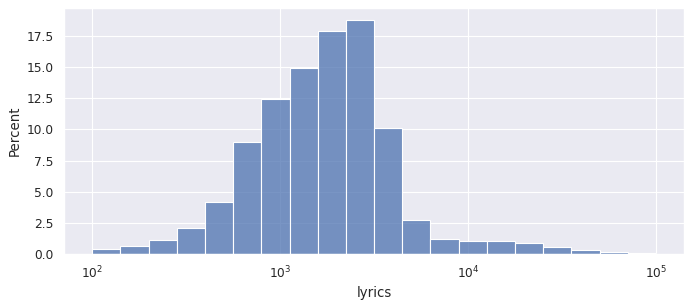

In [17]:
plt.figure(figsize=(10, 4), dpi=80)
sns.histplot(df["lyrics"].str.len(), stat="percent", log_scale=(True, False), bins=20)
plt.show()

Next, we'll take a look at the songs distribution by views, release year and tags. Most of the songs have few views and were released in the last few years. The rap years of genius really show with rap being one of the most prevalent tags.

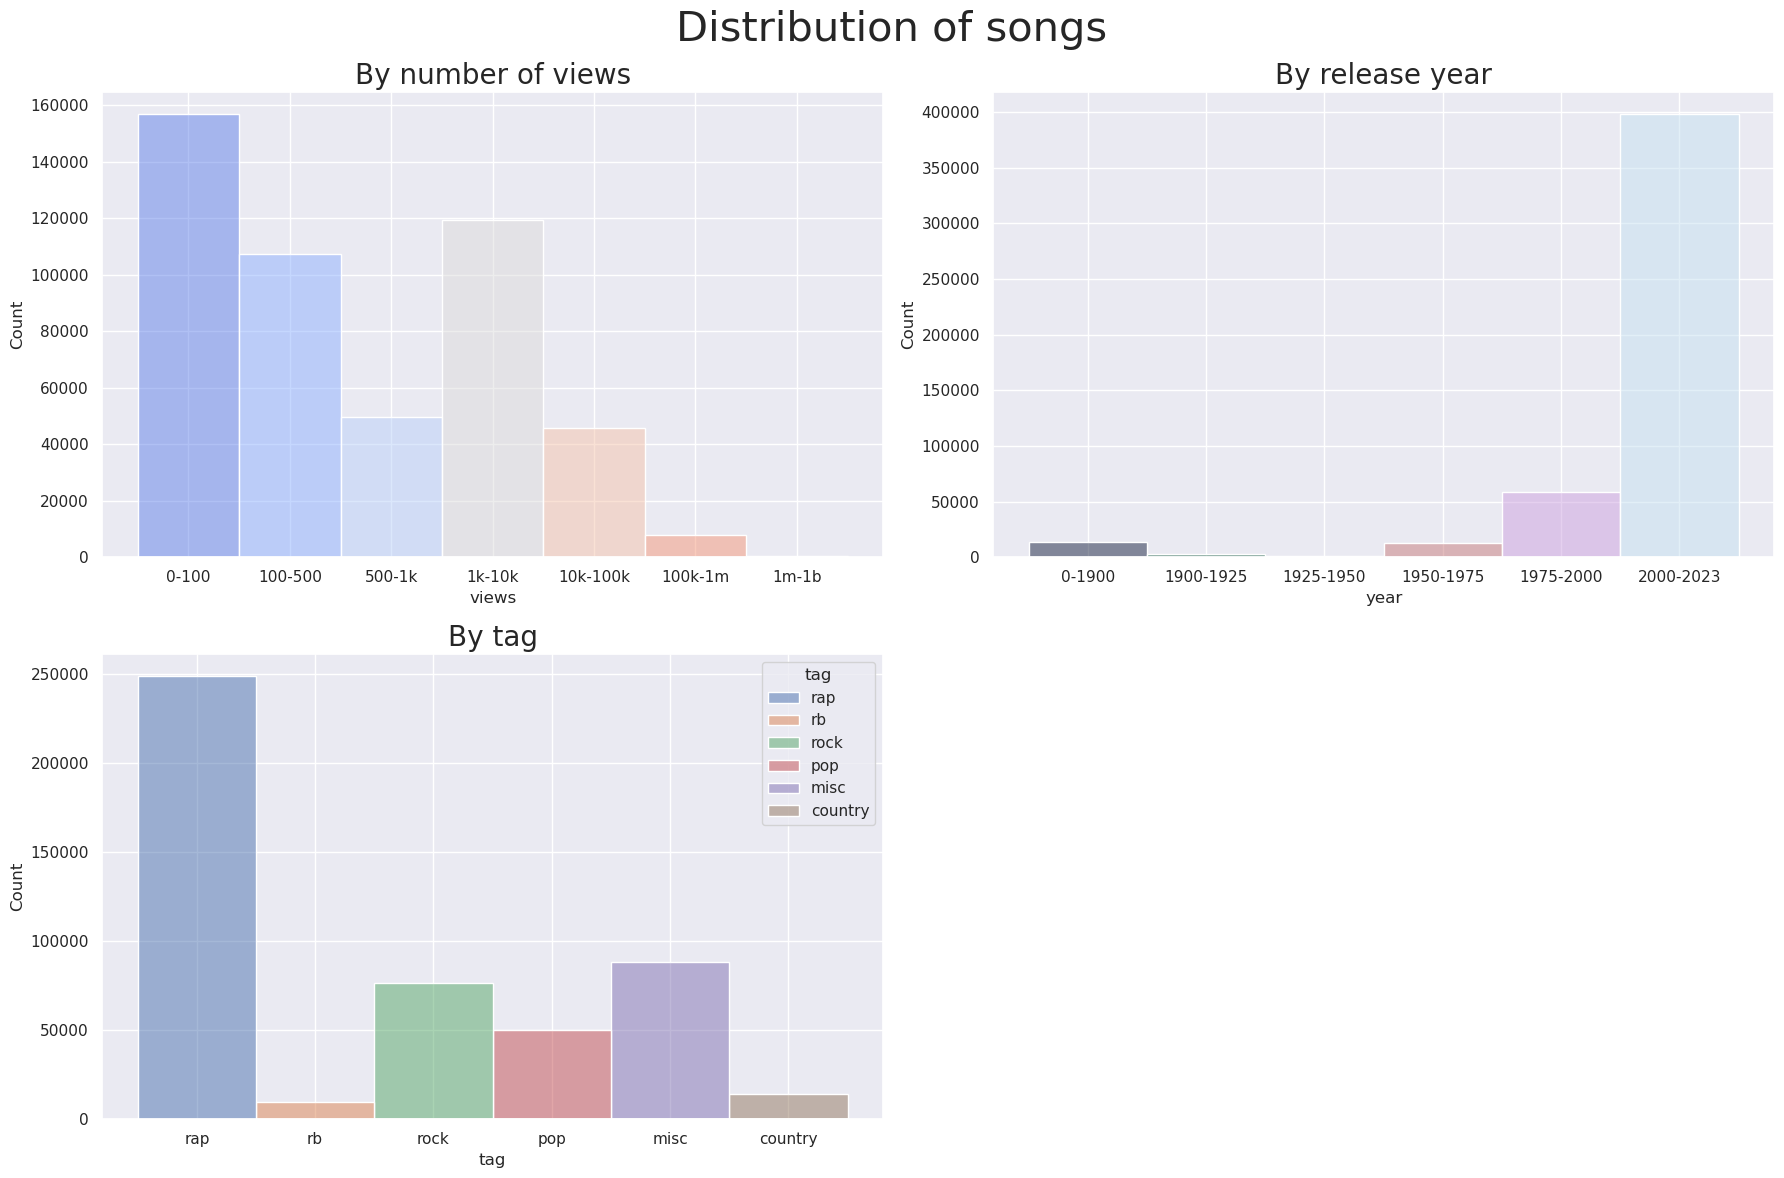

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12), dpi=100, layout="constrained",)

# Views distribution
views_categories = pd.cut(df["views"], bins=[0, 100, 500, 1000, 10 ** 4, 10 ** 5, 10 ** 6, 10 ** 9], include_lowest=True, right=False)
views_categories = views_categories.sort_values().astype(str)
views_bins = views_categories.unique()

sns.histplot(views_categories, ax=ax[0][0])
ax[0][0].set_title("By number of views", fontsize=20)
ax[0][0].xaxis.set_ticks(views_bins)
ax[0][0].set_xticklabels(["0-100", "100-500", "500-1k", "1k-10k", "10k-100k", "100k-1m", "1m-1b"])
for patch, color in zip(ax[0][0].patches, sns.color_palette("coolwarm", n_colors=len(views_bins)).as_hex()):
    patch.set_facecolor((*to_rgb(color), 0.5))


# Years distribution
years_categories = pd.cut(df.loc[df["year"].notna(), "year"], bins=[0, 1900, 1925, 1950, 1975, 2000, 2023], include_lowest=True, right=False)
years_categories = years_categories.sort_values().astype(str)
years_bins = years_categories.unique()

sns.histplot(years_categories, ax=ax[0][1])
ax[0][1].set_title("By release year", fontsize=20)
ax[0][1].xaxis.set_ticks(years_bins)
ax[0][1].set_xticklabels(["0-1900", "1900-1925", "1925-1950", "1950-1975", "1975-2000", "2000-2023"])
for patch, color in zip(ax[0][1].patches, sns.color_palette("cubehelix", n_colors=len(years_bins)).as_hex()):
    patch.set_facecolor((*to_rgb(color), 0.5))

# Tags distribution
sns.histplot(x="tag", hue="tag", data=df, ax=ax[1][0])
ax[1][0].set_title("By tag", fontsize=20)
ax[1][1].remove()
fig.suptitle("Distribution of songs", fontsize=30)
fig.tight_layout()
plt.show()

This following visualization tries to capture the presence of a language in the database with the number of songs and mean popularity of said songs. English is the most prevalent, not so closely followed (logarithmic axis) by languages like Spanish, German, French, Portuguese and some others. Most languages cluster somewhere in the middle, striking a nice balance of presence and popularity. Languages at the bottom right indicate a low number of really popular songs (or one song extremely popular dragging the average up a low)

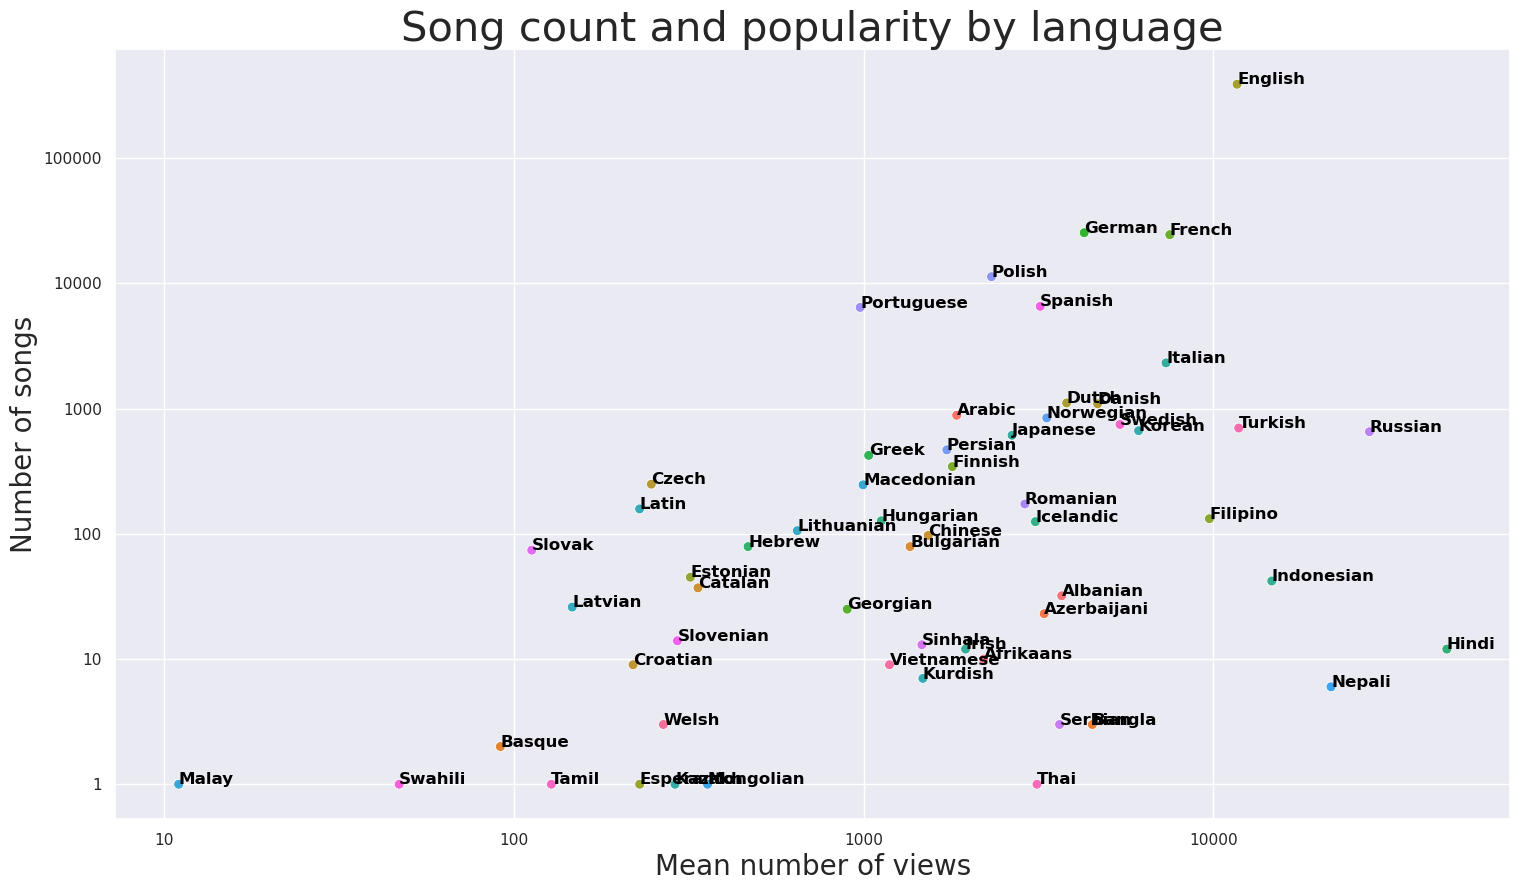

In [19]:
df["language_name"] = df["language"].apply(lambda x: Language.get(x).display_name('en') if pd.notna(x) else np.nan)
lang_df = df.groupby("language_name")["views"].agg([pd.Series.mean, pd.Series.count]).reset_index()

# Plot mean song popularity by language
plt.figure(figsize=(18, 10))
ax = sns.scatterplot(data=lang_df, x="mean", y="count", hue="language_name", legend=False, s=50)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Song count and popularity by language", fontsize=30)
ax.set_xlabel("Mean number of views", fontsize=20)
ax.set_ylabel("Number of songs", fontsize=20)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

for idx, row in lang_df.iterrows():
    ax.text(row["mean"], row["count"], row["language_name"], horizontalalignment="left", size="medium", color="black", weight="semibold")
fig.tight_layout()
plt.show()

# Analyzing english songs
English is the most prevalent language by a considerable margin. Next we'll see if a machine learning technique can extract some information from english songwriting.

In [20]:
df_eng = df[df["language"] == "en"]
df_eng = df_eng.drop(columns=["language", "language_ft", "language_cld3", "language_name"])

Out of all the information we have, the most feasible thing we can hope to achive with a standard clustering approach and lyrics information alone is their tag (genre), so initially we'll compare our results to that, and aim for 6 clusters (as we have 6 tags).

For starters we'll take a look at a word cloud of one of the tags, in this case pop music.

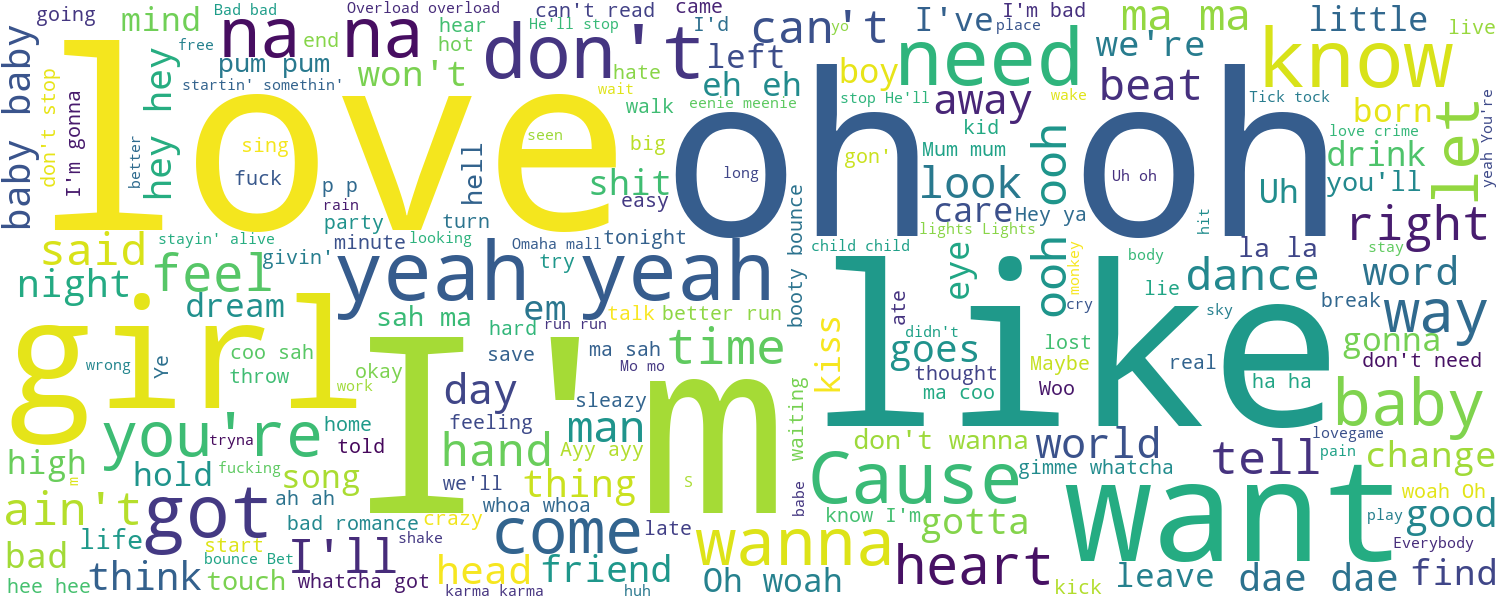

In [22]:
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
wc = WordCloud(background_color="white", width=1500, height=600, stopwords=spacy.lang.en.stop_words.STOP_WORDS)
wc.generate(" ".join(df_eng[df_eng["tag"] == "pop"].loc[:10000, "lyrics"])).to_image()

## Clustering songs
To cluster our songs we'll need to create a way to represent them, as most ml algorithms don't like to work with raw text. To achieve that we use [spacy](https://github.com/explosion/spaCy). Spacy provides an nlp pipeline that (among other things) generates a vector representation of a document in a 300 dimensional space. To achieve that it stores vector representations of a bunch of words that you can download beforehand. It then averages the representation of all words in the document, creating a representation for the whole document.

In [23]:
# Checking a sample vector (1172)
text = df_eng.loc[1661, "lyrics"]
doc = nlp(text)
print(f"vectorn norm: {np.linalg.norm(doc.vector)}")

vectorn norm: 3.292400598526001


The vectors are not normalized

In [24]:
# The vectors are not normalized
from sklearn.preprocessing import normalize
# spacy_vectors = np.array([nlp(text).vector for text in df_eng["lyrics"]])
# X = normalize(spacy_vectors)
X = np.load(os.path.join("data", "ds_toy_en_core_web_large_normalized.npy"))

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=0)

In [26]:
preds = kmeans.predict(X)

Now we can compare the cluster algorithm's predictions to the "real clusters" (tags). As expected, we didn't get an exact match, but we can investigate the relationships our algorithms found.

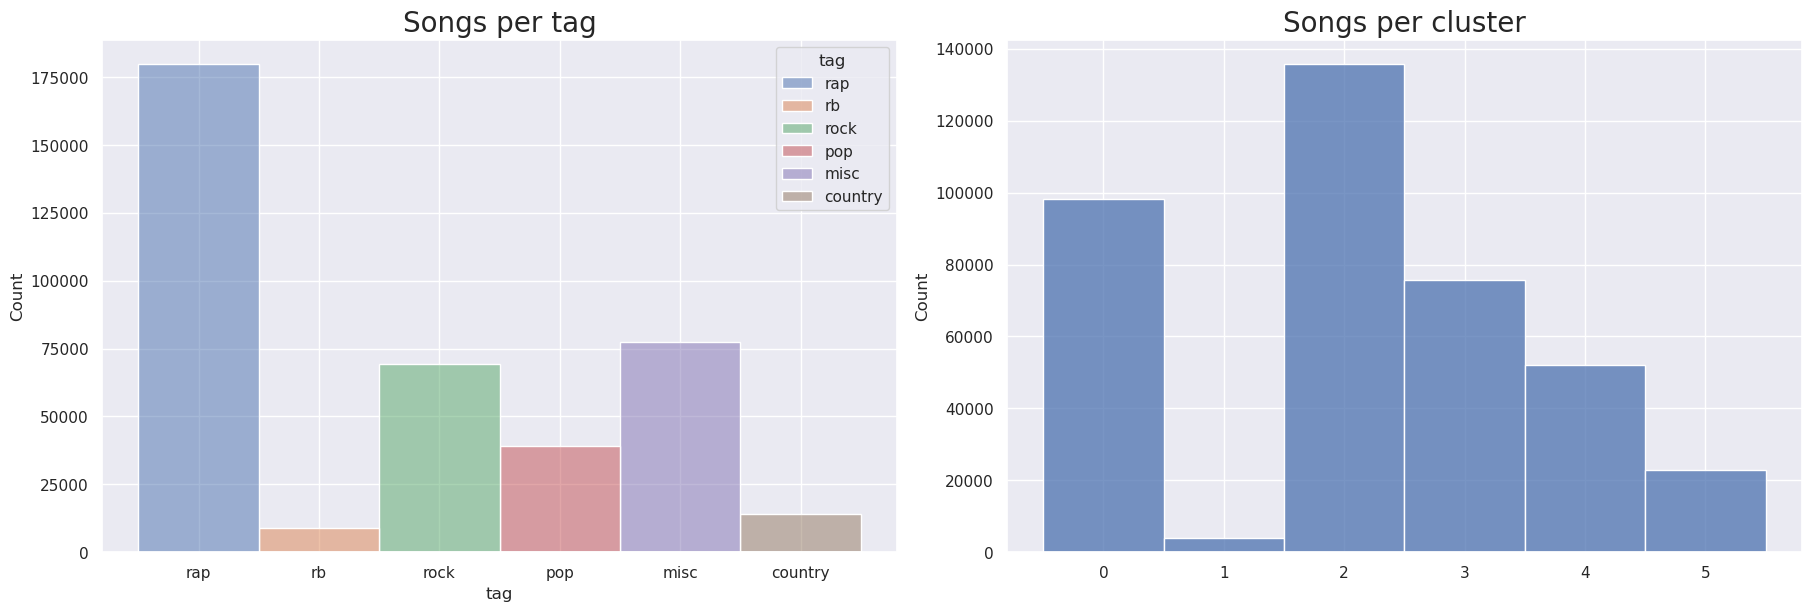

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=100, layout="constrained")
sns.histplot(x="tag", data=df_eng, hue="tag", ax=ax[0])
ax[0].set_title("Songs per tag", fontsize=20)

sns.histplot(preds, bins=6, discrete=True, ax=ax[1])
ax[1].set_title("Songs per cluster", fontsize=20)
plt.show()

The following visualizations break down each cluster, allowing us to see what kinds of songs each of them contains.

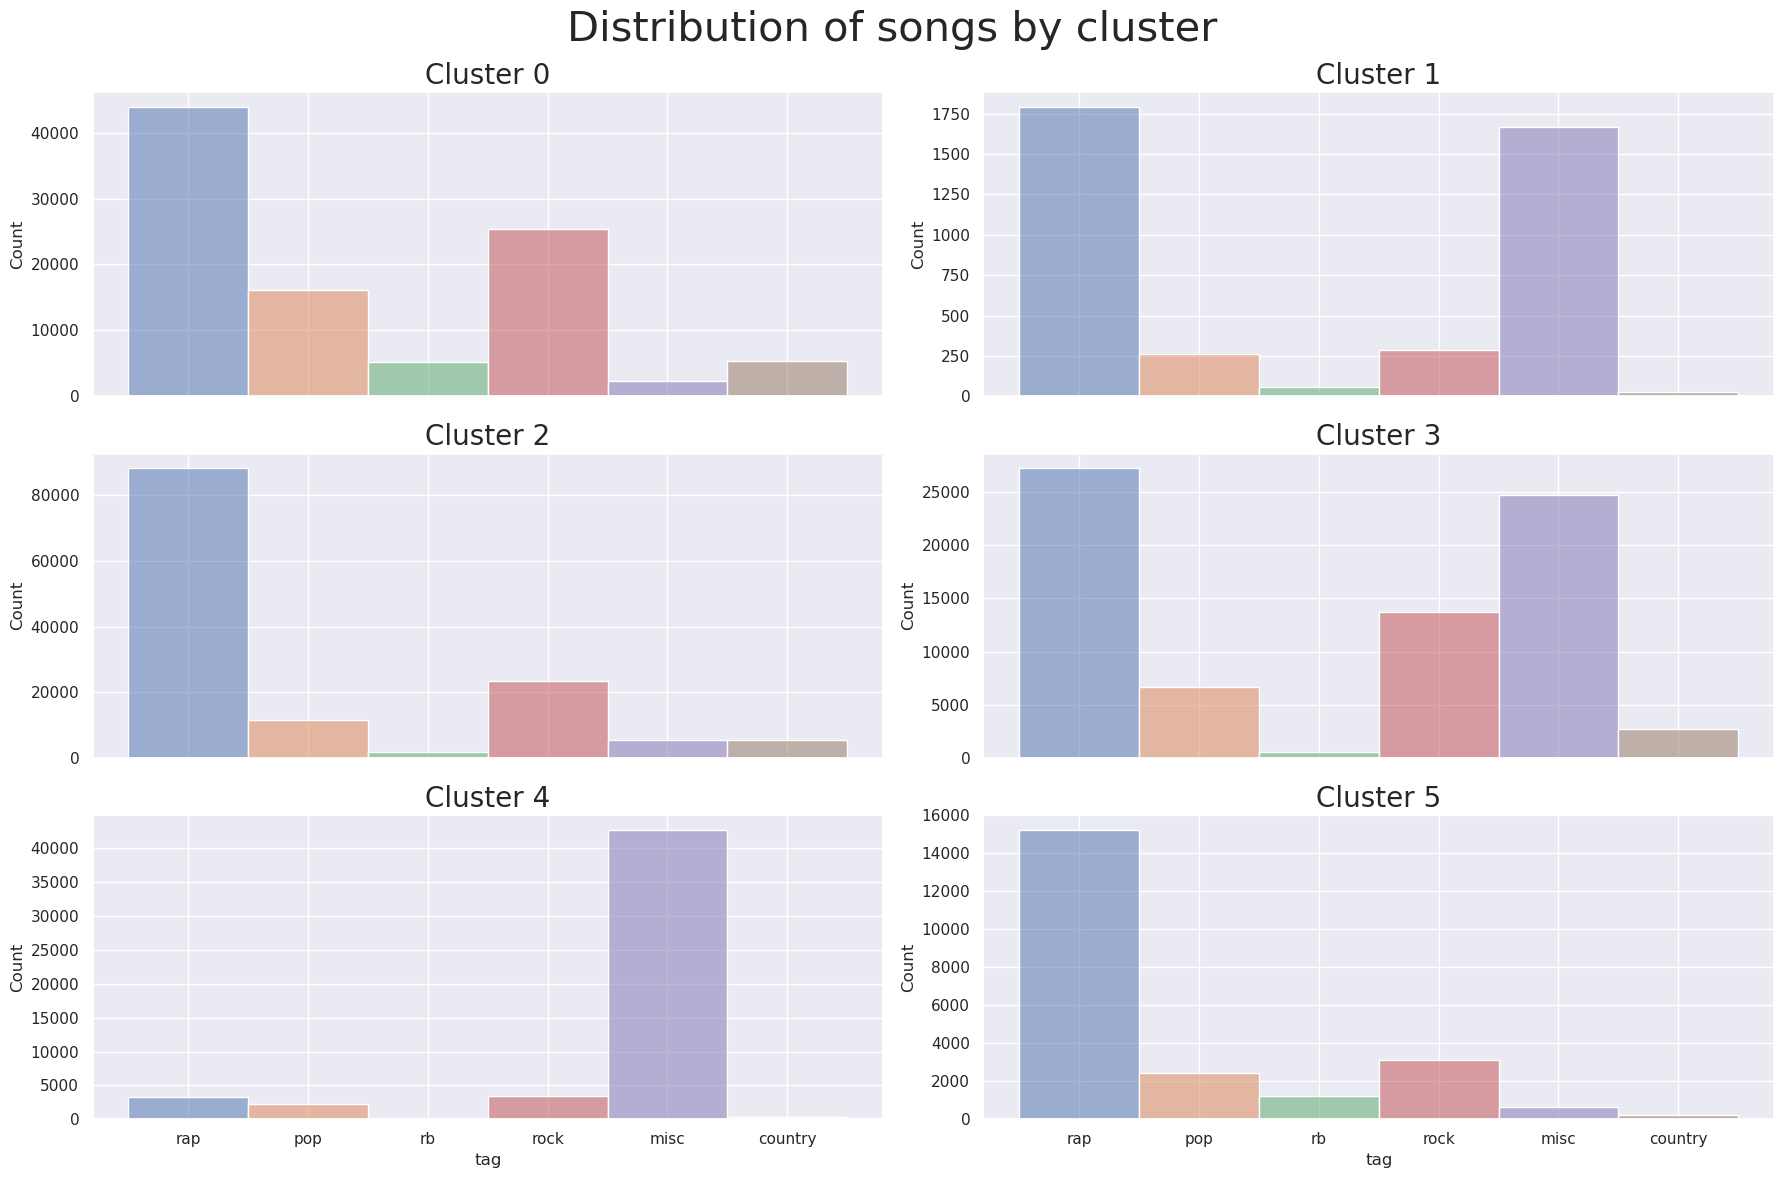

In [28]:
# Visualizing cluster elements
fig, ax = plt.subplots(3, 2, figsize=(18, 12), dpi=100, sharex=True)

cluster_num = 0
for row in range(3):
    for col in range(2):
        sns.histplot(df_eng.loc[preds == cluster_num, "tag"], ax=ax[row][col])
        for patch, color in zip(ax[row][col].patches, sns.color_palette(n_colors=6).as_hex()):
            patch.set_facecolor((*to_rgb(color), 0.5))
        
        ax[row][col].set_title(f"Cluster {cluster_num}", fontsize=20)
        cluster_num += 1

fig.suptitle("Distribution of songs by cluster", fontsize=30)
fig.tight_layout()
plt.show()

One of the clusters in our model did a good job at isolating misc songs. We can investigate this further.

In [29]:
for cluster_num in range(6):
    print(f"Mean length of song in cluster {cluster_num}: {df_eng.loc[preds == cluster_num, 'lyrics'].str.len().mean()}")

Mean length of song in cluster 0: 1581.4888488696254
Mean length of song in cluster 1: 1704.5052477422505
Mean length of song in cluster 2: 2084.058758102534
Mean length of song in cluster 3: 3462.3521941937443
Mean length of song in cluster 4: 7689.49046577655
Mean length of song in cluster 5: 2439.7954169207983


An interesting result. Although the length of the text was never passed as an input to our model (we only used a 300-dimensional representation of each document), our KMeans managed to create one group consisting of considerably larger songs.

In [30]:
print("Some elements in misc")
display(df_eng[df_eng["tag"] == "misc"])
print(f"Average lenght of misc element: {df_eng.loc[df_eng['tag'] == 'misc', 'lyrics'].str.len().mean()}")

Some elements in misc


,title,tag,artist,year,views,lyrics
683,Penny for a Thought,misc,Saul Williams,2001,6118,Cancel the apocalypse! Cartons of the milky wa...
1322,John 1,misc,Holy Bible (KJV),2017,3375,"John 1:1: In the beginning was the Word, and t..."
1323,John 2,misc,Holy Bible (KJV),2017,983,John 2:1: And the third day there was a marria...
1324,John 3,misc,Holy Bible (KJV),2017,2129,"John 3:1: There was a man of the Pharisees, na..."
1383,Do Not Go Gentle Into That Good Night,misc,Dylan Thomas,1951,190091,Do not go gentle into that good night. Old age...
...,...,...,...,...,...,...
491161,Valar Dohaeris,misc,Game of Thrones,2013,6174,EPISODE 1 - VALAR DOHAERISEXT: NORTH OF THE WA...
491194,William Shakespeare’s “Romeo and Juliet Act 1 ...,misc,Dr. Rosalia,2015,1,"PROLOGUE Two households, both alike in dignit..."
492973,On the Run,misc,Easy Star All-Stars,2003,116,"Passengers, please have your passports ready a..."
496329,Watch Me Do Me Classy Skit 2,misc,The Lonely Island,2011,1088,Lonely Island! We takin' over! Yeah! Watch me...


Average lenght of misc element: 7409.924680313499


The original dataset didn't have any indication for what each colum was. I suspected misc was used to indicate other genres of songs, but now it seems that it's main function is to flag non-songs!